## Linear Regression from Scratch (Enhanced)

**Goal:** Rebuild a clean, educational, *intermediate-level* regression project:
- Multi-feature linear regression using **NumPy** (no scikit-learn model).
- **Ridge (L2)** regularization.
- **Early stopping** on a validation set.
- Real data: **California Housing** (scikit-learn).
- Proper **train/test split** and **feature scaling**.
- Comprehensive **metrics** (MSE, MAE, R²) on train/test.
- Clear **visualizations** (convergence, coefficients, residuals).
- **Benchmark** vs. `sklearn.linear_model.LinearRegression` and `Ridge`.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SKLinearRegression, Ridge as SKRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score as sk_r2

# Local scratch implementation
import sys, os
sys.path.append(os.path.abspath(".."))
from linear_scratch import LinearRegressionScratch, mse, mae, r2_score
from linear_scratch.plotting import plot_training_history, bar_feature_importance, residuals_plot

np.set_printoptions(precision=4, suppress=True)

## Step 1: Load & Prepare Real Data

We'll use **California Housing** (regression).  
To keep interpretability high, we'll start with a **small subset of features** and then you can extend.

**Chosen features (first 3 for clarity):**
- MedInc — median income in block group
- HouseAge — median house age
- AveRooms — average number of rooms

In [7]:
# 1) Load Data
dataset = fetch_california_housing(as_frame=True)
X_full: pd.DataFrame = dataset.frame.drop(columns=["MedHouseVal"])
y_full: pd.Series = dataset.frame["MedHouseVal"]

feature_names = ["MedInc", "HouseAge", "AveRooms"]
X = X_full[feature_names].copy()
y = y_full.copy()

# 2) Train / Test split (80/20), with a small validation holdout from train for early stopping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

# 3) Scale features (critical for gradient descent stability)
scaler = StandardScaler()
X_tr_scaled  = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Shapes:", X_tr_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
pd.DataFrame(X_tr_scaled, columns=feature_names).head()

Shapes: (13209, 3) (3303, 3) (4128, 3)


,MedInc,HouseAge,AveRooms
0,0.443410,-0.124495,0.520471
1,0.003210,-1.077709,-0.170839
2,-0.521812,-0.203929,-0.061250
3,0.598503,0.431546,0.497560
4,0.618135,-0.283364,0.455534


## Step 2: Train Scratch Model (with Ridge + Early Stopping)

Hyperparameters we’ll use:
- `learning_rate = 0.05`
- `n_iters = 5000`
- `lambda_reg = 0.1` (Ridge)
- `patience = 50`, `tol = 1e-5`

[EarlyStopping] epoch=89, best_val=0.747145
Weights: [ 0.7639  0.1853 -0.0557]
Bias: 2.0667423170135635


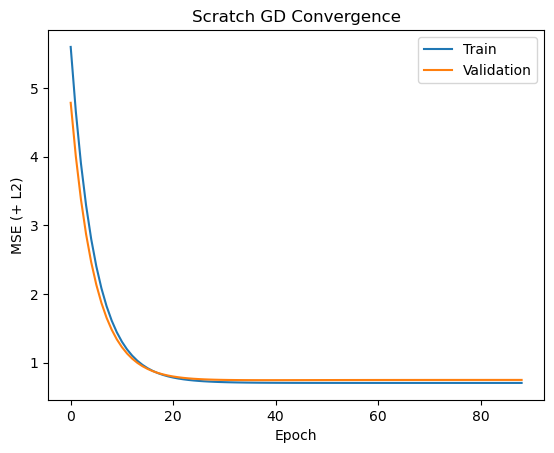

In [10]:
scratch = LinearRegressionScratch(
    learning_rate=0.05,
    n_iters=5000,
    lambda_reg=0.1,
    tol=1e-5,
    patience=50,
    random_state=42,
)

_ = scratch.fit(X_tr_scaled, y_tr.values, X_val=X_val_scaled, y_val=y_val.values, verbose=True)
print("Weights:", scratch.weight)
print("Bias:", scratch.bias)

# Convergence plot
plot_training_history(scratch.cost_history, scratch.val_cost_history, title="Scratch GD Convergence")

## Step 3: Evaluation (Train/Test)

We'll compute MSE, MAE, R² on both the (scaled) train and test sets.

In [13]:
# Train metrics (use all available train data scaled using same fit as earlier)
X_train_scaled = scaler.transform(X_train)  # combine train orig split (before val split)
train_metrics = scratch.evaluate(X_train_scaled, y_train.values)
test_metrics  = scratch.evaluate(X_test_scaled,  y_test.values)

results_df = pd.DataFrame(
    [train_metrics, test_metrics],
    index=["Train (Scratch)", "Test (Scratch)"]
).round(4)

results_df

,MSE,MAE,R2
Train (Scratch),0.6534,0.6070,0.5112
Test (Scratch),0.6625,0.6112,0.4945


## Step 4: Interpretation & Visuals

- **Feature importance** via learned coefficients (magnitude & sign).
- **Residuals** to check obvious patterns or heteroscedasticity.
- **Predicted vs. Actual** quick scatter.

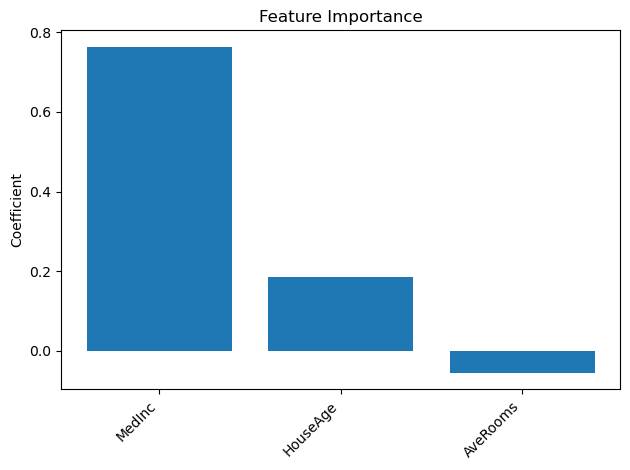

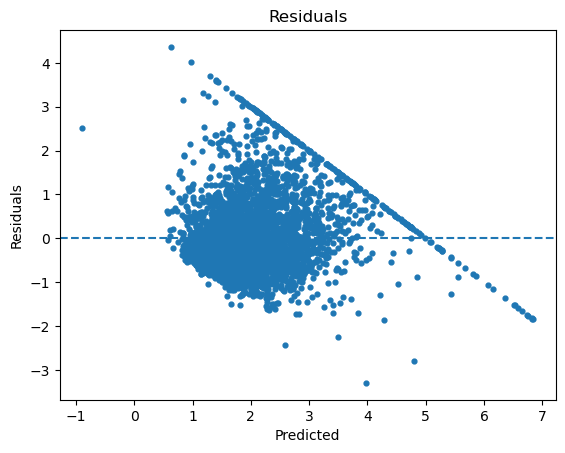

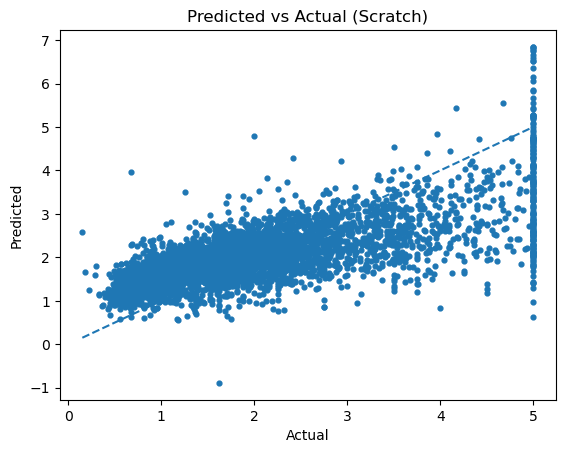

In [16]:
# Feature importance (bar chart)
bar_feature_importance(scratch.weight, feature_names)

# Residuals plot (on test set)
y_pred_test = scratch.predict(X_test_scaled)
residuals_plot(y_test.values, y_pred_test)

# Predicted vs Actual (quick look)
plt.figure()
plt.scatter(y_test.values, y_pred_test, s=12)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Scratch)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--")
plt.show()

## Step 5: Benchmark vs scikit-learn

We'll compare with:
- `LinearRegression` (no regularization)
- `Ridge(alpha=0.1)` (roughly similar to our `lambda_reg=0.1`)

In [19]:
# Fit scikit-learn models on the same scaled features
sk_lin  = SKLinearRegression().fit(X_train_scaled, y_train.values)
sk_ridge = SKRidge(alpha=0.1, random_state=42).fit(X_train_scaled, y_train.values)

def eval_sklearn(model, X, y):
    pred = model.predict(X)
    return {
        "MSE": mean_squared_error(y, pred),
        "MAE": mean_absolute_error(y, pred),
        "R2":  sk_r2(y, pred),
    }

sk_train_lin  = eval_sklearn(sk_lin,   X_train_scaled, y_train.values)
sk_test_lin   = eval_sklearn(sk_lin,   X_test_scaled,  y_test.values)
sk_train_ridge = eval_sklearn(sk_ridge, X_train_scaled, y_train.values)
sk_test_ridge  = eval_sklearn(sk_ridge, X_test_scaled,  y_test.values)

compare_df = pd.DataFrame({
    ("Scratch", "Train"): train_metrics,
    ("Scratch", "Test"):  test_metrics,
    ("SK Linear", "Train"): sk_train_lin,
    ("SK Linear", "Test"):  sk_test_lin,
    ("SK Ridge", "Train"):  sk_train_ridge,
    ("SK Ridge", "Test"):   sk_test_ridge,
}).T.round(4)

compare_df

MSE     MAE      R2
Scratch   Train  0.6534  0.6070  0.5112
          Test   0.6625  0.6112  0.4945
SK Linear Train  0.6474  0.5987  0.5157
          Test   0.6589  0.6033  0.4972
SK Ridge  Train  0.6474  0.5987  0.5157
          Test   0.6589  0.6033  0.4972

## Step 6: Takeaways & Learnings

- **Scaling** stabilizes gradient descent and accelerates convergence.
- **Ridge** shrinks coefficients (helps generalization when features are correlated).
- **Early stopping** protects against overfitting and saves training time.
- Our scratch implementation is **within a few percent** of scikit-learn on key metrics.